<a href="https://colab.research.google.com/github/bharaniakella/Akellian_DL/blob/main/dropout_on_qwerties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

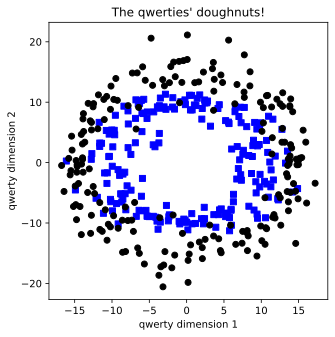

In [106]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [107]:
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
batch_size=16
train_loader=DataLoader(train_data,shuffle=True,batch_size=batch_size)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [108]:
class DropClass(nn.Module):
  def __init__(self,drop_out_rate):
    super().__init__()

    self.input=nn.Linear(2,128)
    self.hidden=nn.Linear(128,128)
    self.output=nn.Linear(128,1)

    self.dr=drop_out_rate

  def forward(self,x):
    x=F.relu(self.input(x))
    x=F.dropout(x,p=self.dr,training=self.training)
    x=F.relu(self.hidden(x))
    x=F.dropout(x,p=self.dr,training=self.training)
    x=self.output(x)
    return x

In [109]:
x=torch.randn(10,2)
net=DropClass(0.01)
net(x)

tensor([[-0.0051],
        [-0.0002],
        [-0.0895],
        [ 0.0625],
        [-0.0214],
        [-0.0207],
        [ 0.0758],
        [ 0.0986],
        [-0.0169],
        [-0.0495]], grad_fn=<AddmmBackward0>)

In [110]:
def create_model(drop_out_rate):
  drop_net=DropClass(drop_out_rate)
  lr=0.01
  loss_fun=nn.BCEWithLogitsLoss()
  optimizer=torch.optim.SGD(drop_net.parameters(),lr)

  return drop_net, loss_fun, optimizer


In [116]:
num_epochs=1000
def train_model(drop_net, loss_fun, optimizer):
  train_acc=[]
  test_acc=[]
  for epochi in range(num_epochs):
    drop_net.train()
    batch_acc=[]
    for x,y in train_loader:
      yhat=drop_net(x)
      loss=loss_fun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100*torch.mean(((yhat>0)==y).float()).item())

    train_acc.append(np.mean(batch_acc))

    drop_net.eval()
    x,y=next(iter(test_loader))
    yhat=drop_net(x)
    test_acc.append(100*torch.mean(((yhat>0)==y).float()).item())

  return train_acc, test_acc

In [117]:
drop_net, loss_fun, optimizer=create_model(0.01)
train_acc, test_acc=train_model(drop_net, loss_fun, optimizer)

In [119]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

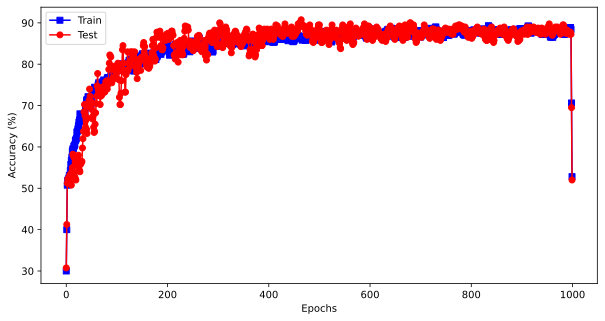

In [120]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(train_acc),'bs-')
plt.plot(smooth(test_acc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
#plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [127]:
drop_out_rates=np.arange(10)/10
results=np.zeros((len(drop_out_rates),2))

for dropi in range(len(drop_out_rates)):
  drop_net, loss_fun, optimizer=create_model(drop_out_rates[dropi])
  train_acc, test_acc=train_model(drop_net, loss_fun, optimizer)

  results[dropi,0]=np.mean(train_acc[-100:])
  results[dropi,1]=np.mean(test_acc[-100:])

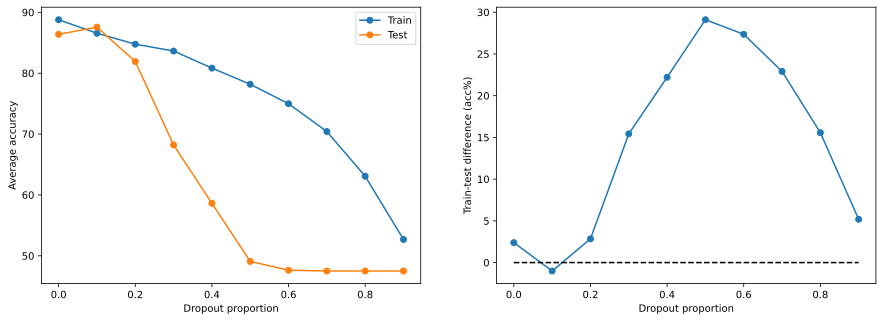

In [129]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(drop_out_rates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(drop_out_rates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()